[View in Colaboratory](https://colab.research.google.com/github/Naren-Jegan/Deep-Learning-Keras/blob/master/Flower_Classifier_V2.ipynb)

In [1]:
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
from PIL import Image, ImageFilter, ImageOps, ImageMath
import random
import pickle
from time import sleep

In [3]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'1.10.1'

In [0]:
flowerspath = os.path.join("drive", "My Drive", "Colab Notebooks", "flowers")

In [0]:
#@title Inputs

activation = 'relu' #@param ['relu', 'softplus', 'tanh', 'sigmoid'] {type:"string"}
learning_rate = 1e-3 #@param {type:"number"}
dropout = 0.48 #@param {type:"slider", min:0.0, max:0.9, step:0.01}
n_epochs = 225 #@param {type:"slider", min:25, max:500, step:25}
batch_size = 128 #@param {type:"slider", min:0, max:1024, step:16}
num_classes = 5 #@param {type:"slider", min:2, max:100, step:1} 

batch_size = 1 if batch_size == 0 else batch_size


In [0]:
#@title Data Augmentation
image_size = 128 #@param {type:"slider", min:32, max:512, step:32}

rotation_range = 40 #@param {type:"slider", min:0, max:90, step:1}
width_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
height_shift_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
shear_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
zoom_range = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
horizontal_flip = True #@param {type:"boolean"}

In [8]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        rescale=1./255,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        os.path.join(flowerspath, 'train'), # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        os.path.join(flowerspath, 'validation'),
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 3423 images belonging to 5 classes.
Found 900 images belonging to 5 classes.


In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# First convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(input_shape=(image_size, image_size, 3), kernel_size=3, strides=1, filters=16, padding='same',
                 activation=activation, name='layer_conv11'))
model.add(BatchNormalization(axis = 3, name = 'bn11'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling1"))

# Second convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation=activation, name='layer_conv21'))
model.add(BatchNormalization(axis = 3, name = 'bn21'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling2"))

# Third convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=64, padding='same',
                 activation=activation, name='layer_conv31'))
model.add(BatchNormalization(axis = 3, name = 'bn31'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling3"))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())


model.add(Dropout(dropout))
# First fully-connected / dense layer with activation.
model.add(Dense(1024, activation=activation, name = "dense_1"))
model.add(BatchNormalization(axis = 1, name = 'bn8'))

model.add(Dropout(dropout))
# Second fully-connected / dense layer with activation.
model.add(Dense(1024, activation=activation, name = "dense_2"))
model.add(BatchNormalization(axis = 1, name = 'bn9'))

model.add(Dense(num_classes, activation='softmax', name = "dense_3"))

In [0]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=learning_rate)

In [0]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit_generator(train_generator, 
                    steps_per_epoch= sum([len(files) for r, d, files in os.walk(os.path.join(flowerspath, "train"))])//batch_size,
                    epochs=n_epochs,
                    validation_data = validation_generator,
                    validation_steps= sum([len(files) for r, d, files in os.walk(os.path.join(flowerspath, "validation"))])//batch_size
         )

Epoch 1/225
26/26 [==============================] - 37s 1s/step - loss: 1.9342 - acc: 0.4320 - val_loss: 2.4456 - val_acc: 0.2009
Epoch 2/225
26/26 [==============================] - 32s 1s/step - loss: 1.4230 - acc: 0.4972 - val_loss: 3.9542 - val_acc: 0.2009
Epoch 3/225
26/26 [==============================] - 32s 1s/step - loss: 1.1398 - acc: 0.5771 - val_loss: 6.1382 - val_acc: 0.2009
Epoch 4/225
26/26 [==============================] - 32s 1s/step - loss: 1.0082 - acc: 0.6132 - val_loss: 7.0869 - val_acc: 0.2009
Epoch 5/225
26/26 [==============================] - 31s 1s/step - loss: 0.9976 - acc: 0.6186 - val_loss: 8.0463 - val_acc: 0.2009
Epoch 6/225
26/26 [==============================] - 31s 1s/step - loss: 0.9254 - acc: 0.6436 - val_loss: 9.4107 - val_acc: 0.2009
Epoch 7/225
26/26 [==============================] - 30s 1s/step - loss: 0.8963 - acc: 0.6547 - val_loss: 7.0034 - val_acc: 0.2009
Epoch 8/225
26/26 [==============================] - 31s 1s/step - loss: 0.8514 - a

In [0]:
from IPython import display

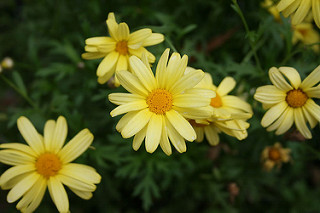

daisy predicted as daisy


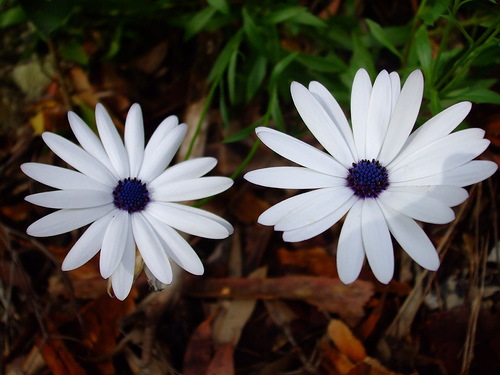

daisy predicted as daisy


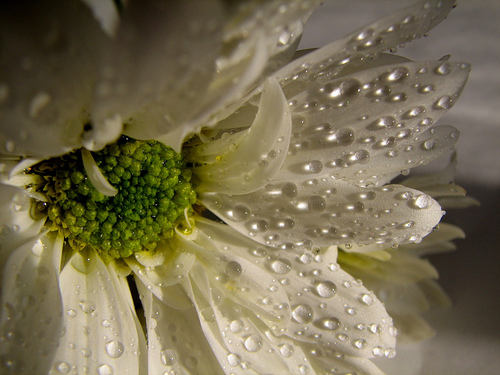

daisy predicted as rose


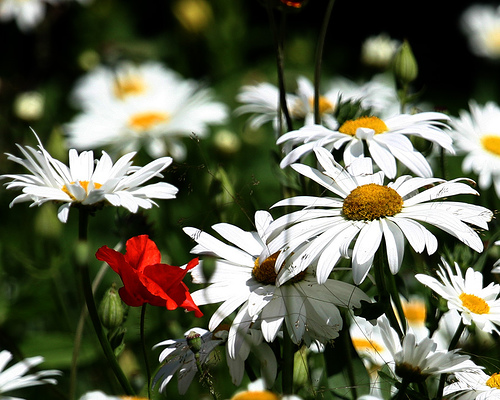

daisy predicted as daisy


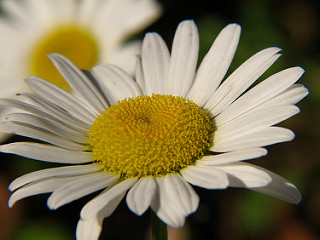

daisy predicted as daisy


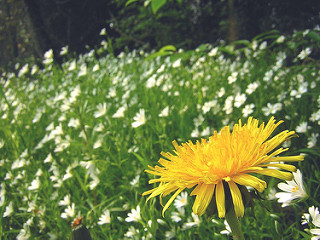

dandelion predicted as daisy


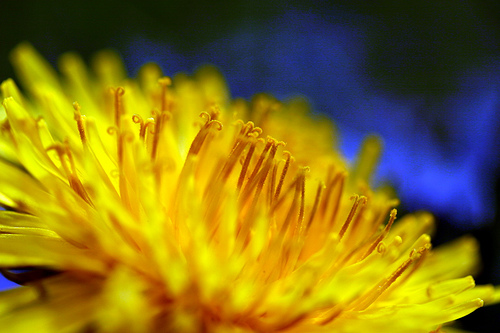

dandelion predicted as dandelion


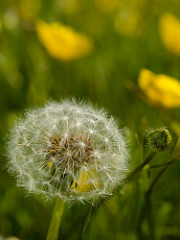

dandelion predicted as dandelion


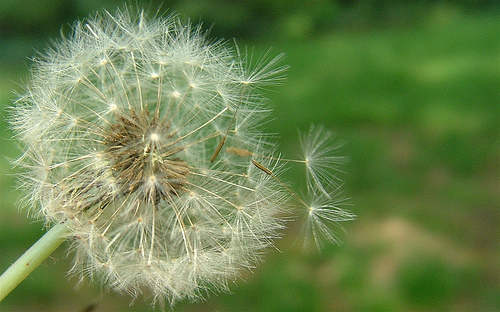

dandelion predicted as dandelion


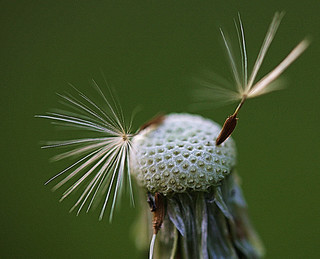

dandelion predicted as dandelion


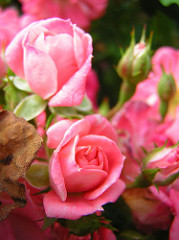

rose predicted as rose


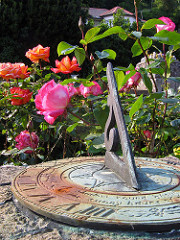

rose predicted as tulip


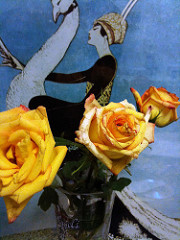

rose predicted as sunflower


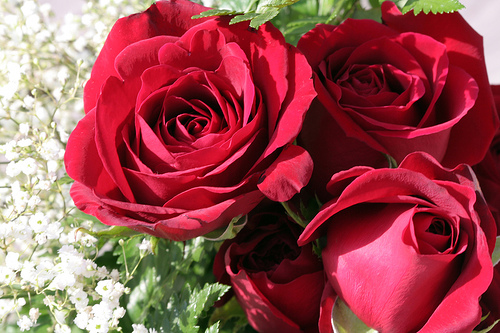

rose predicted as rose


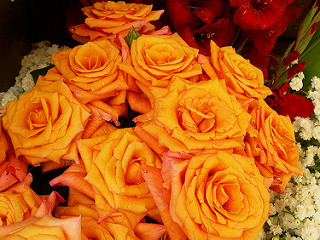

rose predicted as rose


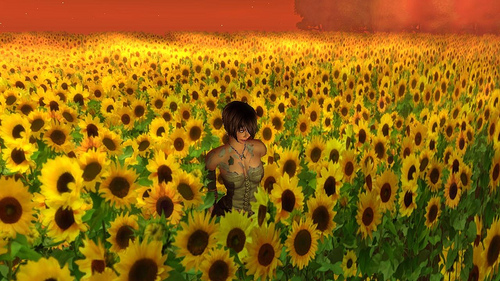

sunflower predicted as sunflower


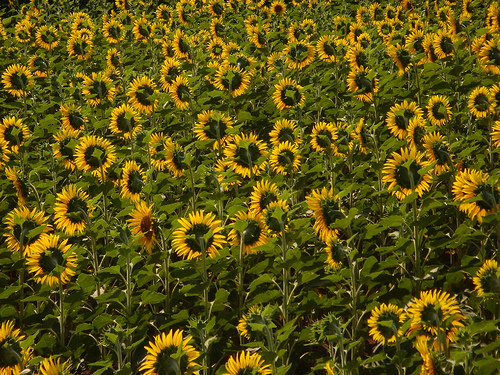

sunflower predicted as sunflower


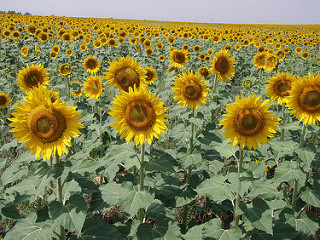

sunflower predicted as sunflower


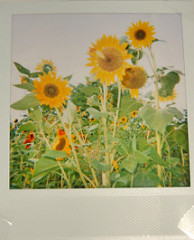

sunflower predicted as sunflower


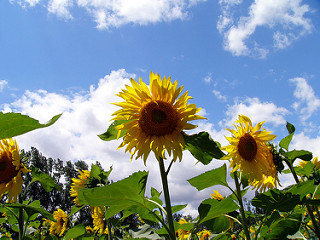

sunflower predicted as sunflower


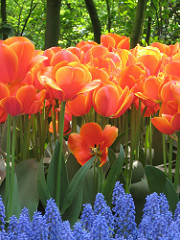

tulip predicted as tulip


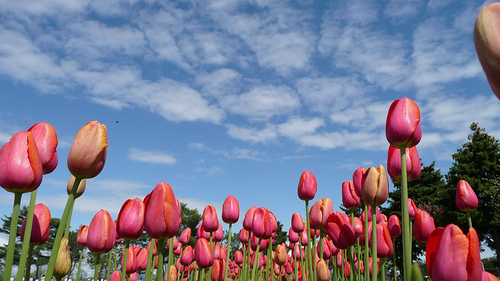

tulip predicted as tulip


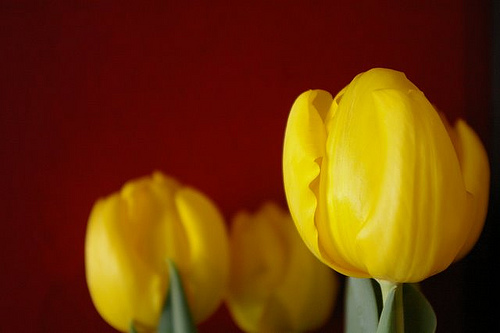

tulip predicted as tulip


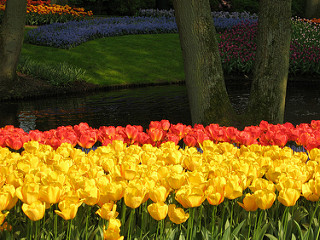

tulip predicted as tulip


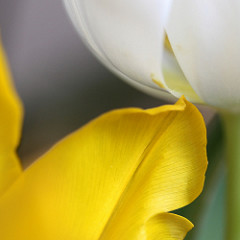

tulip predicted as dandelion
accuracy: 80.0


In [14]:
valid_dir = os.path.join(flowerspath, "validation")
flower_list = sorted(os.listdir(valid_dir))
count = 0
for flower_type in flower_list:
  flowers = os.listdir(os.path.join(valid_dir, flower_type))
  for i in range(5):
    flower = os.path.join(valid_dir, flower_type, random.choice(flowers)) 
    img = Image.open(flower).convert('RGB')
    img = img.resize((image_size, image_size), Image.ANTIALIAS)
    arr = np.array(img).reshape((1,image_size, image_size, 3))

    pred = model.predict(arr*(1./255)).argmax(axis=-1)[0]
    display.display(display.Image(flower))
    print(flower_type + " predicted as " + flower_list[pred])
    count += (1 if flower_type == flower_list[pred] else 0)
print("accuracy: " + str(count*100/(5*len(flower_list))))